In [ ]:
#This is the code for the current FracTool function. It classifies the signals as fBm and fGn and then omits the
#fBm signals from further analysis

#The cell loads the fMRI signal, takes a slice, and calls FracTool on every voxel in the slice. The outputs are saved
#in the "Outputs" folder in FractalDimension

#The function itself is another Jupyter notebook in FractalDimension "FracTool_Final_Function"

#You can change the signal by changing the file name in example_slice = ''
#Here are filenames of some I have been using: 
# 'SCI_Pilot_08/SCI_Pilot_08_fMRI_Slice.nii.gz' this is the 317 time-point signal
# 'Long-timeseries_OpenfMRI/sub-06_ses-movie_task-movie_bold_mcf.nii.gz' this is sub06 (3600 time-points)

#The python scripts are in FractalDimension
#FracTool_Call.py loads the signal and calls FracTool 
#FracTool_Final.py is the FracTool function
#Make sure you are in the FractalDimension directory in the terminal
#Give permission for the file 
#Run the script from the terminal with ./FracTool_Final.py
#The outputs will be:
#1) Text file of Hurst values
#2) Text file of Class values
#3) Heatmap of the Hurst exponenent
#4) Heatmap of the Class 
#They are saved to the "Outputs folder in FractalDimension"


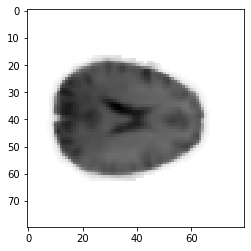

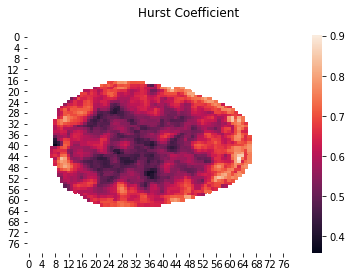

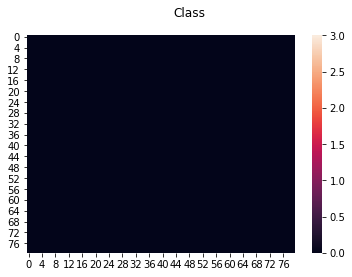

In [2]:
import multiprocessing
from joblib import Parallel, delayed
import os 
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from ipynb.fs.defs.FracTool_Final_Function import FracTool
from ipynb.fs.defs.forfun import FracTool



#load sample slice and convert to np array
example_slice = 'sub-01_movie_mcf.ica/filtered_func_data_clean01.nii.gz'
slice_img = nib.load(example_slice, mmap=False)
slice_array = slice_img.get_fdata()
#pick your slice here (ex: [:,:,20,:]) is slice 20
#pick the range of your signal here (ex: [:,:,20,0:500]) is the first 500 time-points of slice 20)
slice_sq = slice_array[:,:,20,0:2250]


#images of slice:
#imgplot = plt.imshow(slice_sq[:,:,1])
imgplot = plt.imshow(slice_sq[:,:,1],cmap='Greys',  interpolation='nearest')
plt.show()


[N1,N2,N3] = slice_sq.shape
row = np.arange(0,N1)
column = np.arange(0,N2)
TR = 2.0 #temporal resolution of signal 

def FracTool_voxel(i, j):
    '''This function returns the Hurst coefficient and class of each voxel in the slice'''
    global TR
    rawbold = (slice_sq[i,j])
    result = FracTool(rawbold, TR) #run Fractool on each signal in signal array
    H_val = result[1] #result[1] of FracTool is Hurst value
    Class_val = result[0] #result[0] of FracTool is Class
    return result #result is array of 2 elements

#multiprocessing for loop
num_cores = multiprocessing.cpu_count()
output = Parallel(n_jobs=num_cores)(delayed(FracTool_voxel)(i,j) for i in row for j in column)
#output is j*i length list of result (2 values in each result)

output = np.array(output) #convert output into numpy array
output = output.astype(np.float64) #convert type object list elements to type float

Class_matrix = output[:,0] #first column of result output array of result is class
Hurst_matrix = output[:,1] #second column of result output array of result is Hurst 

#generate heat maps
Hurst_matrix = Hurst_matrix.reshape(N1,N2)
np.savetxt('Outputs/Hurst_matrix.txt',Hurst_matrix,fmt='%.2f')
Hurst_map = sns.heatmap(Hurst_matrix)
Hurst_fig = Hurst_map.get_figure()
Hurst_fig.suptitle('Hurst Coefficient')
Hurst_fig.savefig('Outputs/Hurst_Heatmap.png')
plt.show()

Class_matrix = Class_matrix.reshape(N1,N2)
np.savetxt('Outputs/Class_matrix.txt',Class_matrix,fmt='%.2f')
Class_map = sns.heatmap(Class_matrix, vmin=0, vmax=3)
Class_fig = Class_map.get_figure()
Class_fig.suptitle('Class')
Class_fig.savefig('Outputs/Class_Heatmap.png')
plt.show()
